In [1]:
#Confirmando a versão Python em utilização. 

from platform import python_version
print(python_version())

3.9.13


# Importando os pacotes 

In [2]:
# Instala o pacote de dados imdb-sqlite, com informações de uma enorme quantidade de filmes. 
# Estruturada em SQLite, uma solução rápida e leve para bancos de dados relacionais. 

!pip install -q imdb-sqlite

In [3]:
# Instala o pacote
# https://pypi.org/project/pycountry/
# Esse pacote será útil quando quisermos analisar quastões ligadas a países e idiomas. 
!pip install -q pycountry

In [4]:
# Importando pacotes já disponíveis no Jupyter Notebook e Anaconda. 

import re                # utilizado para textos e expressões regulares
import time              # tempo de execução e datas
import sqlite3           # manipular bancos de dados SQLite
import pycountry
import numpy as np       #pandas e numpy são excelentes soluções para manipulação de dados em Python
import pandas as pd
import matplotlib.pyplot as plt    #matplotlib e seaborn servem principalmente para "plotar" gráficos e visualizar dados                                # em Python
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer        #Queremos apenas uma função desse pacote de Machine Learning
import warnings                                                    # Esses pacote será útil para despoluir os avisos de erro
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

# Carregando os dados 

In [6]:
#O símbolo de exclamação indica que o comando será executado no prompt de comando, enquanto os sinais "%%" irão nos mostrar o tempo de execução

%%time
!imdb-sqlite

UsageError: Line magic function `%%time` not found.


In [7]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")
cur = conn.cursor()

In [8]:
# Após conectarmos uma variável Python no banco de dados, queremos analisar melhor os conteúdos disponíveis nas tabelas! 
# Para isso, utilizaremos o pacote Pandas para extrairmos essas informações mais facilmente. 
# Utilizaremos um comando em SQL (query) para extrairmos o nome das tabelas disponíveis. 
# SQLite_master é uma tabela "catálogo", que lista o conteúdo das tabelas

tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [9]:
#Saber o tipo dos dados nos permite consultar a documentação do pacote e compreender como podemos explorá-lo!

type(tabelas)

pandas.core.frame.DataFrame

In [10]:
#Nome das tabelas disponíveis
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [11]:
# Convertendo para o formato "list" de Python
tabelas = tabelas["Table_Name"].values.tolist()

In [12]:
# Percorrendo a lista de tabelas e extraindo o modelo de cada uma delas
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela) #
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# Análise exploratória dos dados IMDB


1- Quais são as categorias mais recorrentes da história do audiovisual? 

In [13]:
# Para responder essa pergunta, utilizaremos uma consulta SQL, que irá nos retornar a contagem por tipo
consulta1 = '''SELECT type, COUNT(*) AS contagem FROM titles GROUP BY type'''

In [14]:
# Aplicando essa query, conseguimos visualizar os tipos mais populares de produções cinematográficas :)
# Há também a possibilidade de utilizarmos formas de "sorting" com Pandas, como veremos adiante
resultado1 = pd.read_sql_query(consulta1, conn)
display(resultado1)

,type,contagem
0,movie,626445
1,short,898671
2,tvEpisode,7062443
3,tvMiniSeries,45861
4,tvMovie,138149
5,tvPilot,2
6,tvSeries,233840
7,tvShort,10731
8,tvSpecial,38957
9,video,266861


In [15]:
# Aqui criamos uma nova coluna calculada, semelhante ao que podemos fazer em Excel e PowerBI. 
# O default da função "sort_values" é ascendente, então se quisermos verificar primeiro quem são os maiores devemos passar um parâmetro "false"
resultado1['Percentual'] = (resultado1['contagem'] / resultado1['contagem'].sum()) * 100
display(resultado1)
display(resultado1.sort_values(by='contagem', ascending=False))

,type,contagem,Percentual
0,movie,626445,6.696600
1,short,898671,9.606653
2,tvEpisode,7062443,75.496418
3,tvMiniSeries,45861,0.490247
4,tvMovie,138149,1.476791
5,tvPilot,2,0.000021
6,tvSeries,233840,2.499713
7,tvShort,10731,0.114713
8,tvSpecial,38957,0.416444
9,video,266861,2.852703


,type,contagem,Percentual
2,tvEpisode,7062443,75.496418
1,short,898671,9.606653
0,movie,626445,6.696600
9,video,266861,2.852703
6,tvSeries,233840,2.499713
4,tvMovie,138149,1.476791
3,tvMiniSeries,45861,0.490247
8,tvSpecial,38957,0.416444
10,videoGame,32713,0.349697
7,tvShort,10731,0.114713


Visualização dos dados usando matplotlib


In [16]:
# Vamos supor que você é um alto executivo de uma produtora de filmes, ou mesmo um empreendedor recém chegado no setor visual.
# Você precisa contratar funcionários que atendam à demanda específica dos tipos mais comuns e rentáveis de audiovisual.
# Por isso, é preciso analisar graficamente os tipos mais comuns de produção e, por hora, ignorar as particularidades dos outros. 
# Iremos escolher os três tipos mais populares e manter suas individualidades, enquanto os outros irão permanecer agrupados em um dicionário Python.
outros = {}

outros['Percentual'] = resultado1[resultado1['Percentual'] < 5]['Percentual'].sum()
outros['contagem'] = resultado1[resultado1['Percentual'] < 5]['contagem'].sum()
outros['type'] = 'outro'

outros

{'Percentual': 8.200329396869352, 'contagem': 767114, 'type': 'outro'}

In [17]:
resultado1 = resultado1[resultado1['Percentual'] > 5]


In [18]:
resultado1 =  resultado1.append(outros, ignore_index=True)

In [19]:
resultado1 = resultado1.sort_values(by='Percentual', ascending=False)
resultado1

,type,contagem,Percentual
2,tvEpisode,7062443,75.496418
1,short,898671,9.606653
3,outro,767114,8.200329
0,movie,626445,6.696600


In [20]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['Percentual'][i],2))+'%'+']'for i in resultado1.index]


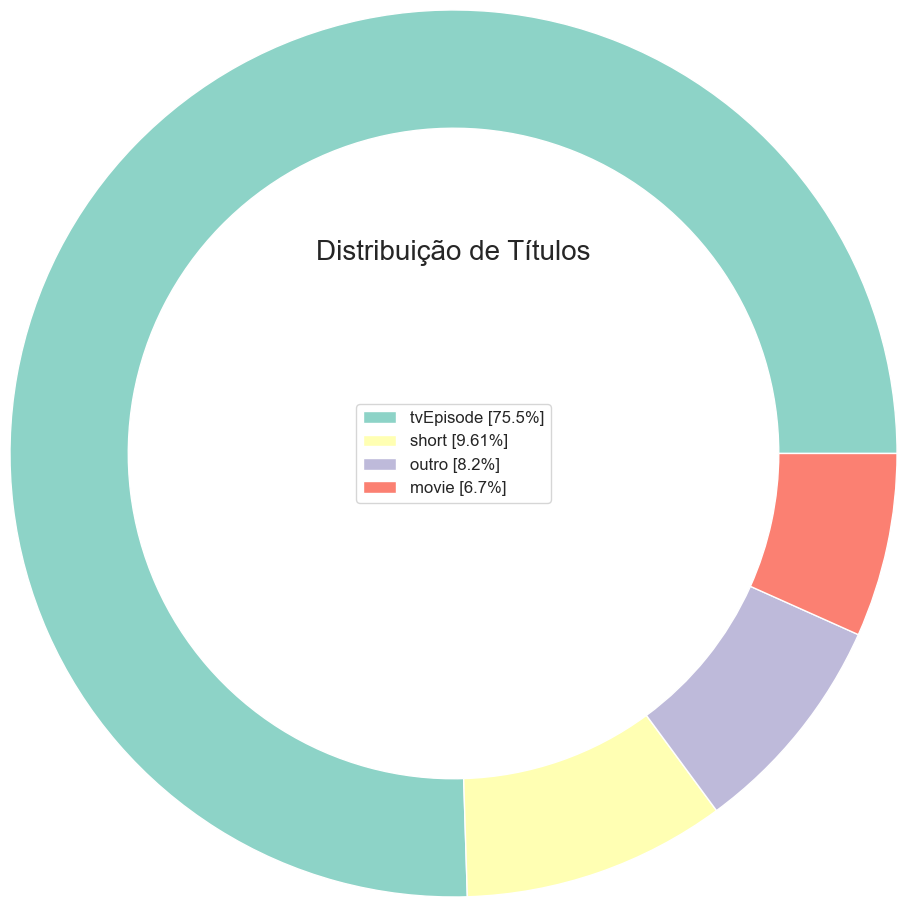

In [21]:
cs = cm.Set3(np.arange(100))
f = plt.figure()
plt.pie(resultado1['contagem'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

Número de títulos por gênero

In [22]:
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type= 'movie' GROUP BY genres'''

In [23]:
resultado2 = pd.read_sql_query(consulta2, conn)
print(resultado2.sort_values(by='COUNT(*)', ascending=False))

                              genres  COUNT(*)
1075                           Drama    116327
959                      Documentary     89752
1470                              \N     72007
708                           Comedy     44527
1327                          Horror     15682
...                              ...       ...
1103          Drama,Film-Noir,Horror         1
377   Adventure,Documentary,Thriller         1
389       Adventure,Drama,Reality-TV         1
415           Adventure,Fantasy,News         1
359            Adventure,Crime,Sport         1

[1471 rows x 2 columns]


In [24]:
# Função lower para padronizar as entradas

resultado2['genres'] = resultado2['genres'].str.lower().values



In [25]:
#Não queremos tratar de valores nulos

temp = resultado2['genres'].dropna()

In [26]:
# Agora percebemos que há um leve problema: muitos filmes não se encaixam em apena uma categoria, como drama, ação ou terror. 
# Dessa forma, seria muito contraproducente analisar cada combinação específica (como aventura, crime e esporte, que possui apenas
# uma entrada), por isso iremos utilizar uma matriz de zeros e uns, também chamada de matriz de encode (ou esparsa).
# Assim, transformamos valores de "genres", que é um valor categórico, em zeros e uns, permitindo que as funções calculem mais facilmente a soma. 

padrao = '(?u)\\b[\\w-]+\\b'#essa é uma expressão regular Python, que basicamente diz ao programa como analisar as strings
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)




In [27]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [28]:
bag_generos = vetor.transform(temp)

In [29]:
# Agora estamos transformando nosso vetor em uma "matrix sparse", que ainda precisa ser especificada
type(bag_generos)

scipy.sparse._csr.csr_matrix

In [30]:
generos_unicos =  vetor.get_feature_names()
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'n',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [31]:
# Utilizamos o pacote Pandas para transformar essa matrix em um DataFrame (ou tabela), mais fácil de ser manipulada
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [32]:
# Eliminando uma coluna residual
generos = generos.drop(columns = 'n', axis = 0)

In [34]:
# Calculando o percentual de aparições de cada gênero
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending= False) / generos.shape[0]


In [35]:
generos_percentual.head()

drama          17.946975
comedy         17.131203
documentary    15.975527
adventure      14.683889
action         14.547927
dtype: float64

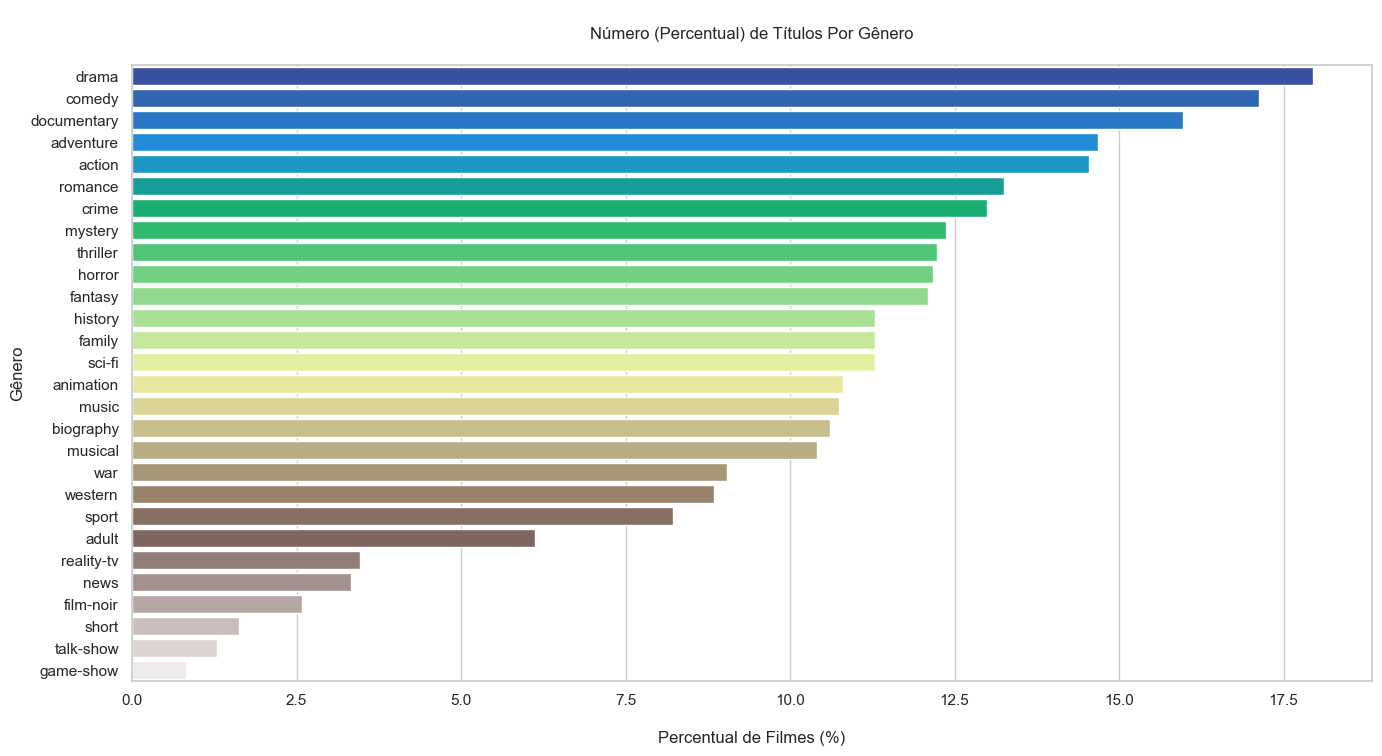

In [36]:
# Utilizando os pacotes de visualização de dados para plotar o gráfico

plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

# Avaliando a mediana das avaliações por gênero

In [164]:
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [165]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [168]:
# Novamente encontramos o problema da análise acima, em que certos filmes se enquadram em diferentes gêneros. 
# Assim, precisamos transformar o esquema em uma matriz esparsa. Como teremos essa necessidade adiante, é producente modularizar o código

def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [169]:
generos_unicos = retorna_generos(resultado3)

In [170]:
len(generos_unicos)

28

In [171]:
genero_counts = []
genero_ratings = []


In [172]:
for item in generos_unicos:
    #contando a quantidade de ratings por gênero
     # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [173]:
# Preparando os dataframes
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [174]:
df_genero_ratings.values

array([['action', 29307, 5.8],
       ['adult', 4103, 5.7],
       ['adventure', 17761, 6.0],
       ['animation', 4868, 6.6],
       ['biography', 8709, 7.0],
       ['comedy', 69849, 6.0],
       ['crime', 24314, 6.1],
       ['documentary', 42813, 7.3],
       ['drama', 125483, 6.4],
       ['family', 10925, 6.3],
       ['fantasy', 8427, 6.1],
       ['film-noir', 854, 6.5],
       ['game-show', 8, 8.05],
       ['history', 7855, 6.9],
       ['horror', 20290, 5.0],
       ['music', 12795, 6.6],
       ['musical', 6243, 6.3],
       ['mystery', 10680, 6.0],
       ['news', 655, 7.3],
       ['reality-tv', 47, 6.8],
       ['romance', 31503, 6.2],
       ['sci-fi', 6712, 5.4],
       ['short', 22, 7.300000000000001],
       ['sport', 3452, 6.7],
       ['talk-show', 14, 6.25],
       ['thriller', 23509, 5.6],
       ['war', 5990, 6.6],
       ['western', 5047, 6.0]], dtype=object)

In [175]:
df_genero_ratings = df_genero_ratings.drop(index=18)

In [176]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

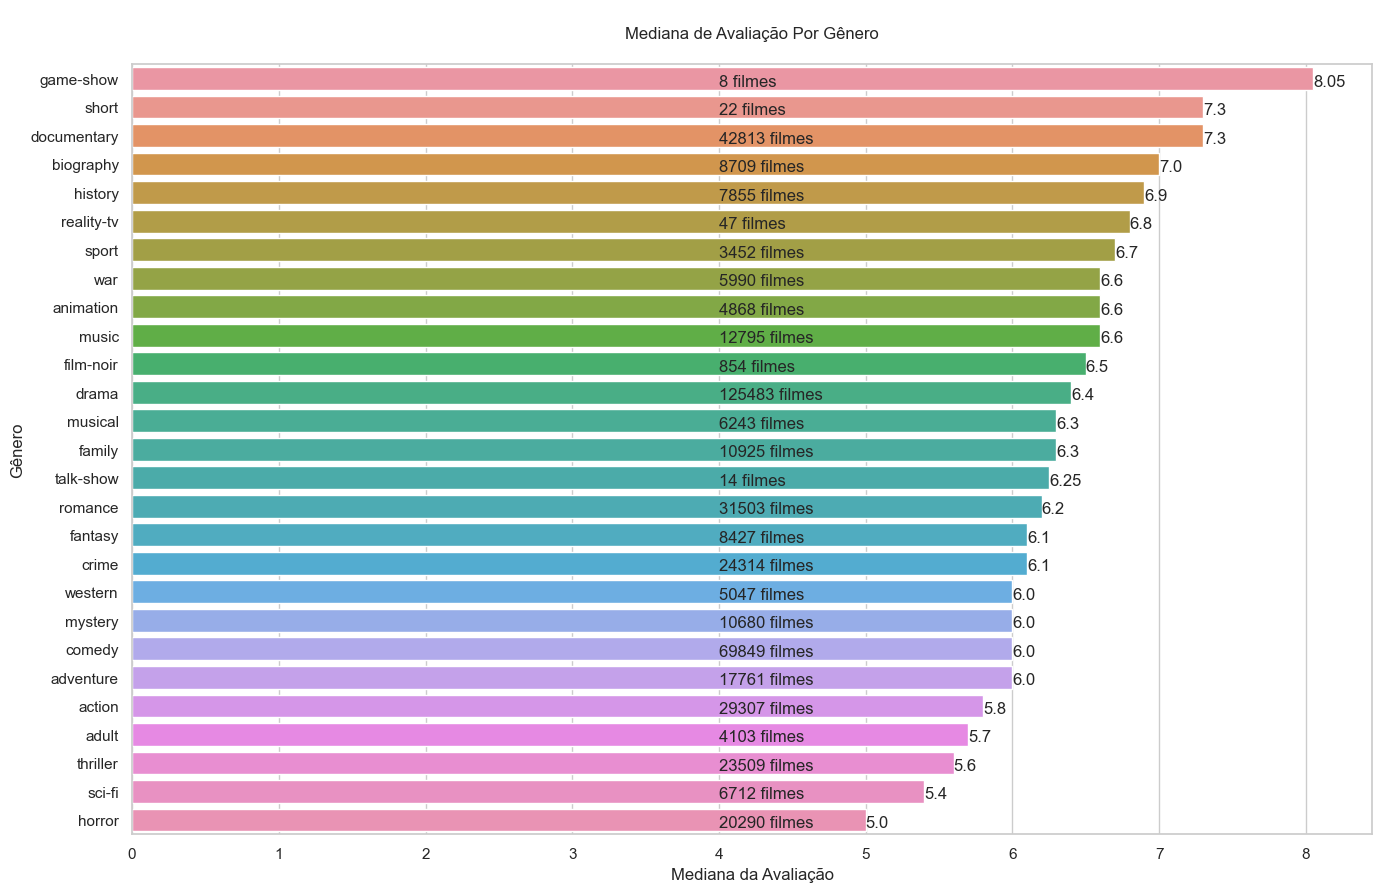

In [177]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

# Qual a mediana de avaliaçao dos filmes em relaçao ao ano de estreia?

In [178]:
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [179]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [180]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [181]:
anos = list(set(resultado4['premiered']))

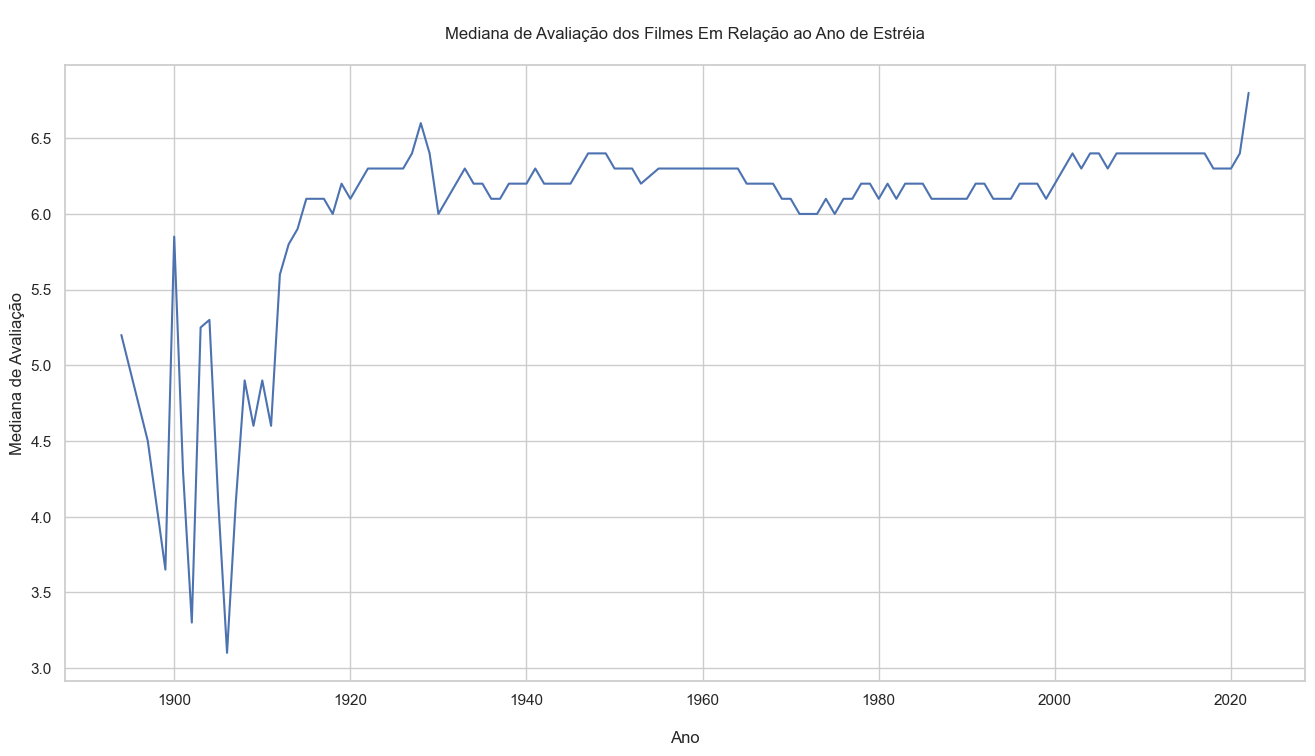

In [182]:
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

Podemos verificar que os filmes mais recentes são muito mais assistidos, e por isso apresentam medianas mais constantes

# Qual o número de filmes avaliados por gênero em relação ao ano de estreia?

In [191]:
consulta5 = '''SELECT genres FROM titles ''' 

In [192]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [193]:
generos_unicos = retorna_generos(resultado5)

In [194]:
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [195]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [196]:
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

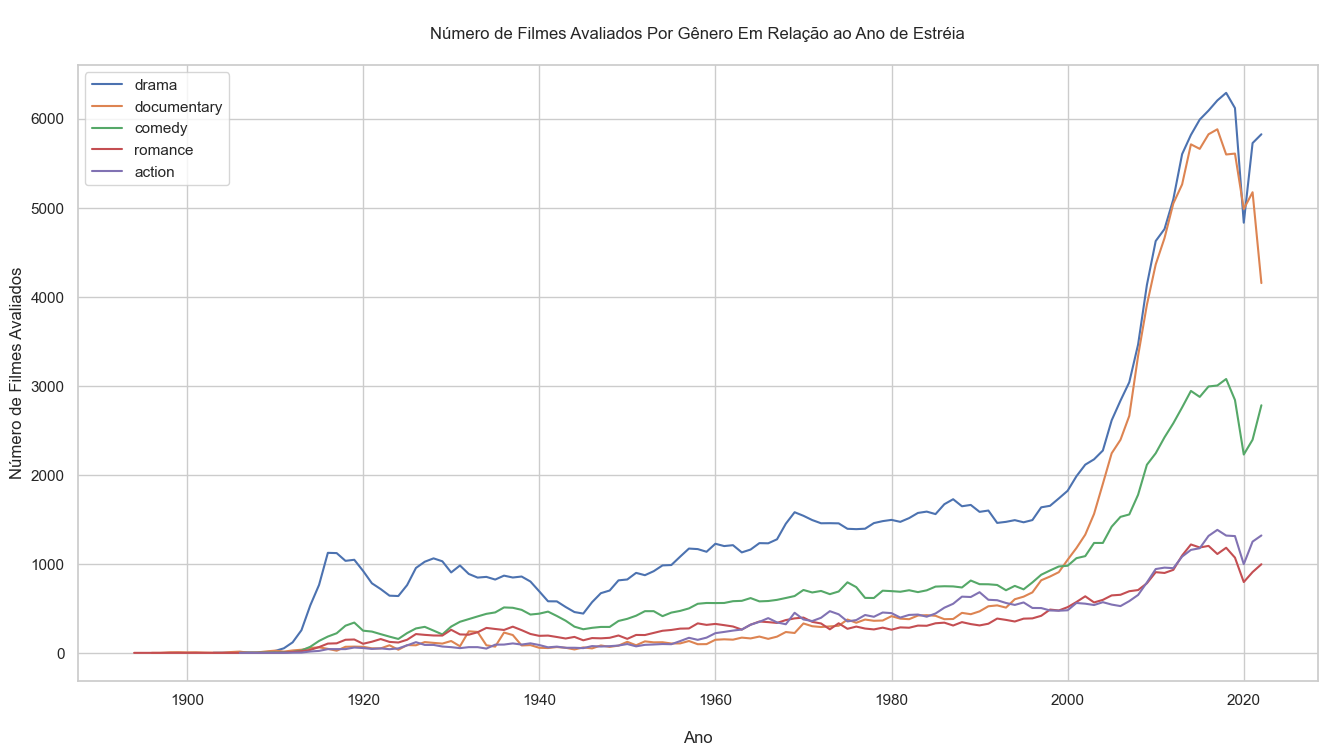

In [197]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

# Qual o título de maior duração?

In [200]:
consulta6 = '''SELECT primary_title, runtime_minutes AS Runtime FROM titles WHERE type = 'movie' AND Runtime != 'NaN' 
                ORDER BY Runtime DESC
                LIMIT 1
            '''

In [201]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [202]:
# Aparentemente se trata de uma dupla de diretores que decidiram expor as "estranhas do capitalismo" e mostrar toda a lógica
# da produção e distribuição das mercadorias. Interessante. Dizem que na segunda vez assistindo fica ainda melhor. 
print(resultado6)

  primary_title  Runtime
0     Logistics    51420


# Qual a relação entre duração e gênero?

In [205]:
consulta7 = '''SELECT genres, AVG(runtime_minutes) FROM titles WHERE type = 'movie' AND runtime_minutes != 'NaN' 
            GROUP BY genres'''

In [206]:
resultado7 = pd.read_sql_query(consulta7, conn)

In [207]:
print(resultado7)

                      genres  AVG(runtime_minutes)
0                     Action             99.336487
1               Action,Adult             76.181818
2     Action,Adult,Adventure             85.000000
3        Action,Adult,Comedy             76.400000
4         Action,Adult,Crime             85.375000
...                      ...                   ...
1383        Thriller,Western             94.800000
1384                     War             94.127214
1385             War,Western             92.538462
1386                 Western             69.995813
1387                      \N             82.512252

[1388 rows x 2 columns]


In [208]:
generos_unicos = retorna_generos(resultado7)

In [215]:
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [216]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [217]:
# Remove índice 18 (news): julgo que não é realmente um gênero cinematográfico
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [218]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

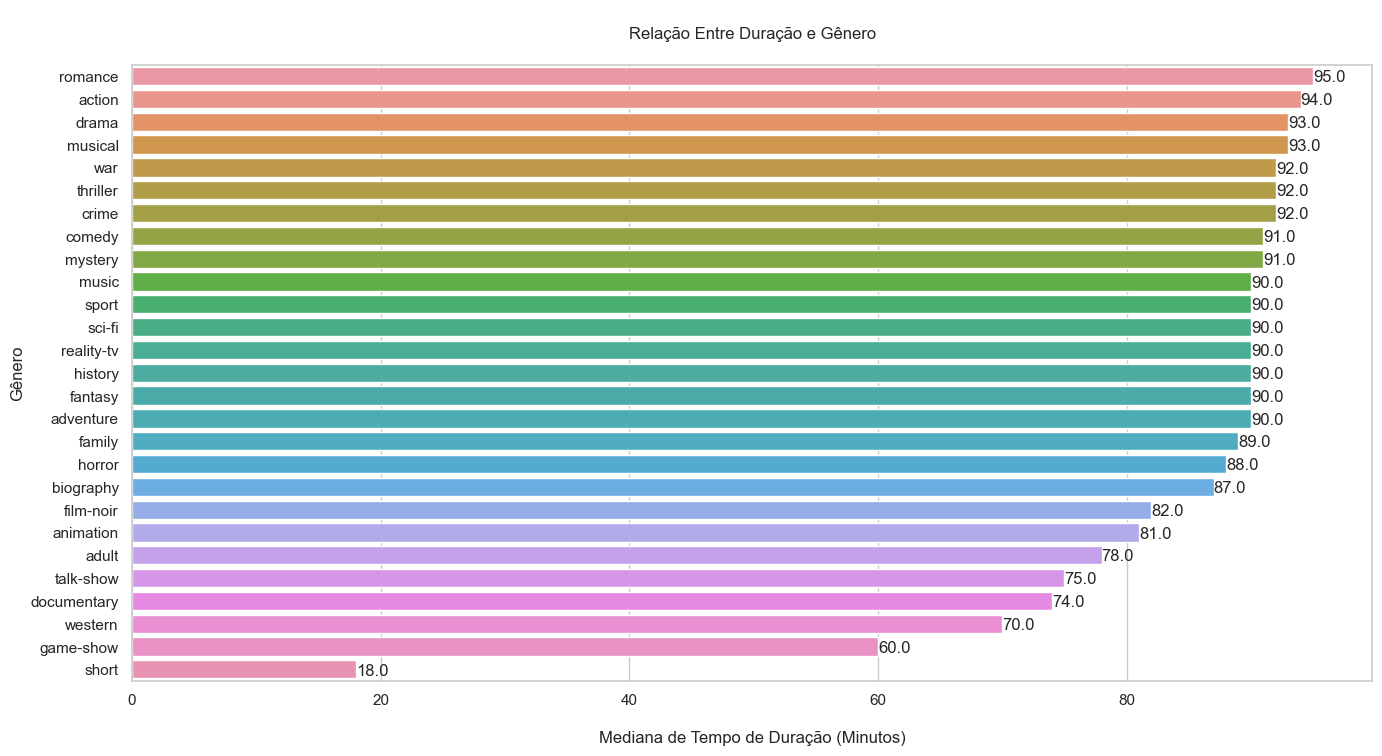

In [219]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

Apesar da pouca diferença relativa, poderiamos dizer que os gêneros mais associados ao cinema antigo (noir e western) possuem uma duração média menor. Talvez isso se dê pela própria tradição do período de fazerem filmes um tanto menores. 

# Qual o número de filmes produzidos por país?

In [247]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [248]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [273]:

print(resultado8)

    region  Number_of_movies
0       AD                22
1       AE              8674
2       AF               112
3       AG                12
4       AL              1307
..     ...               ...
230   YUCS               152
231     ZA             10408
232     ZM                47
233   ZRCD                 2
234     ZW                55

[235 rows x 2 columns]


In [249]:
nomes_paises = []
contagem = []

In [250]:
# Para decifrarmos esses códigos do database IMDB, iremos utilizar o pacote pycountry. 
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [251]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [252]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [253]:
df_filmes_paises.head(10)

,country,Movie_Count
200,United States,319614
66,United Kingdom,162458
97,Japan,94725
90,India,89774
64,France,87199
32,Canada,83307
48,Germany,74303
59,Spain,68052
94,Italy,67634
26,Brazil,66996


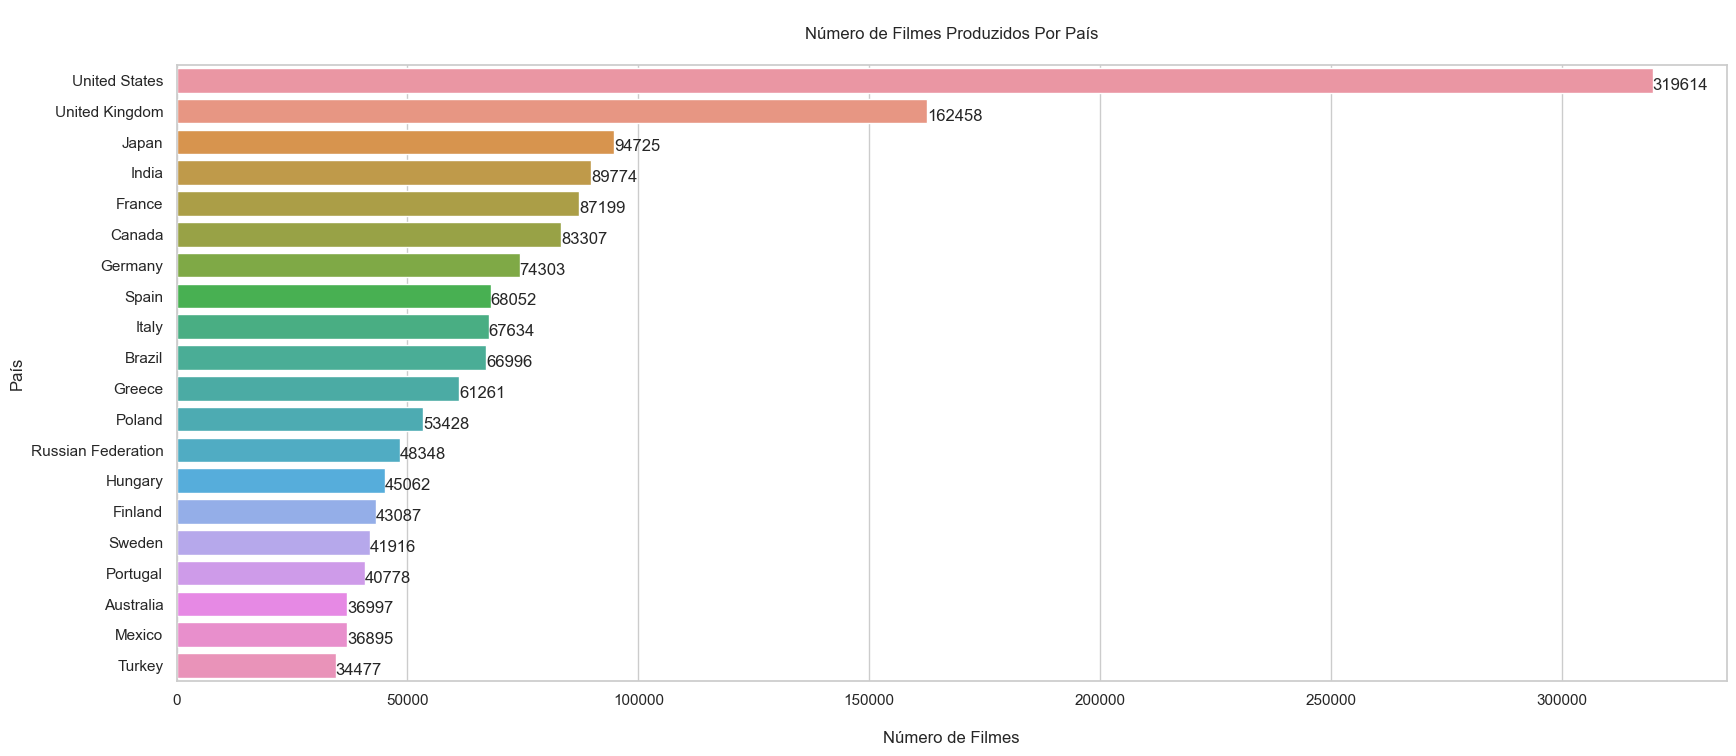

In [254]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# Quais são os 10 melhores filmes?

In [265]:
consulta9 = '''SELECT primary_title AS Movie_names, genres, rating FROM titles
            JOIN ratings ON titles.title_id = ratings.title_id
            WHERE titles.type='movie' AND ratings.votes >= 30000
            ORDER BY rating DESC
            LIMIT 10'''

In [266]:
resultado9 = pd.read_sql_query(consulta9, conn)

In [268]:
display(resultado9)

,Movie_names,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,Kantara,"Action,Adventure,Drama",9.1
4,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather Part II,"Crime,Drama",9.0
7,Schindler's List,"Biography,Drama,History",9.0
8,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


Como tudo na vida, os trolls e a sacanagem ocupam todos os espaços deixados à mostra. Esse filme de index 4 é aparentemente uma sitcom turca que foi alvo de uma mobilização ativa de avaliações positivas (ou seja, uma pegadinha coletiva). 

# Quais são os 10 piores filmes?

In [269]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [270]:
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [271]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Action,Crime,Drama",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9


Sacanearam com o Justin Bieber

# Conclusão

Como o atento leitor, e interpretador, deve muito bem ter percebido, não há nada de excessivamente complicado nesse notebook. E isso denota novamente a força de Python, uma linguagem tão eficaz que em poucas células conseguimos extrair informações valiosas de um database de mais de 10GB. Utilizando de SQL e de diversos pacotes, conseguimos verificar os melhores e piores filmes, a relação entre gêneros e durações e mesmo tendências de produção cinematográficas. E isso com poucas linhas de código. Como ainda sou um mero iniciante em Python, pretendo incrementar a análise desse database, já que adoro cinema e creio que podemos analisar ainda outras questões, como atores e bilheterias. Até mais!